# For what is this notebook for?
- Defining shortcut and anti-shortcut examples in multiple-choice QA.

# Import & Definition

In [1]:
import os
import torch
import numpy as np
import math
from tqdm import tqdm
from pathlib import Path
from collections import Counter, defaultdict
from squad import SquadV1Processor, SquadExample
import spacy
nlp = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt
from utils import load_json, save_json
import seaborn as sns
sns.set()

In [7]:
race_dir = os.environ['RACE_DIR']
reclor_dir = os.environ['ReClor_DIR']
analysis_dir = os.environ['RE_ANALYSIS_DIR']

In [8]:
def print_mcqa_example(ex):
    """
    example_id: str
    question: str
    contexts: List[str]
    endings: List[str]
    label: Optional[str]
    """
    print("----")
    print("ID:", ex.example_id)
    print("Context 📗: ", ex.contexts[0])
    print()
    print("Question 💡:", ex.question)
    print("Options 🌿:", ex.endings)
    print("Answer 🍎:", ex.label)
    print("----")

In [9]:
def print_exqa_example(ex):
    print("----")
    print("ID:", ex.qas_id)
    print("Context 📗: ", ex.context_text)
    print()
    print("Question 💡:", ex.question_text)
    print("Answer 🍎:", ex.answers)
    print("----")

In [10]:
def print_race_examples(ex):
    assert isinstance(ex, dict)
    print("----")
    if 'example_id' in ex:
        print("ID:", ex.example_id)
    elif 'id' in ex['document']:
        print("DocID:", ex['document']['id'])
    print("Context 📗: ", ex['document']['summary']['text'])
    print()
    print("Question 💡:", ex['question']['text'])
    print("Answers 🍎:", [_a['text'] for _a in ex['answers']])
    print("----")

In [11]:
def get_analysis_result(key, name, task_type='ex-qa'):
    analysis_task_dir = Path(analysis_dir) / task_type
    analysis_file = analysis_task_dir / f"{key}_{name}.json"
    analysis_result = load_json(analysis_file)
    return analysis_result

In [12]:
def get_offset_id2w(doc):
    # from char index to word index
    id2w = {}
    tm1 = 0
    for i, t in enumerate(doc):
        for j in range(tm1, t.idx):
            # t.idx: char-level start position of t (token)
            id2w[j] = i - 1
        tm1 = t.idx
    for j in range(t.idx, t.idx+len(t)+1):
        id2w[j] = i
    return id2w

def get_common_ngram(sent1, sent2, n):
    """
    sent1, sent2 (str): lower cased tokens joined with spaces
    n (int): n-gram
    """
    if len(sent1.split()) < n or len(sent2.split()) < n:
        return 0
    m = 0
    tokens = sent2.split()
    for i in range(len(tokens) - n + 1):
        ngram = tokens[i:i+n]
        assert len(ngram) == n
        ngram = ' '.join(ngram)
        if ngram in sent1:
            m += 1
    return m

# EX-QA

In [5]:
DATASET_DIR = Path('dataset')

In [6]:
processor = SquadV1Processor()
file = DATASET_DIR / 'ex-qa/squad/train-v1.1.json'
squad_train_examples = processor.get_train_examples(None, filename=file, do_lower_case=False)

100%|██████████| 442/442 [00:41<00:00, 10.60it/s]


In [14]:
processor = SquadV1Processor()
file = DATASET_DIR / 'ex-qa/squad/dev-v1.1.json'
squad_dev_examples = processor.get_train_examples(None, filename=file, do_lower_case=False)

100%|██████████| 48/48 [00:04<00:00,  9.79it/s]


In [555]:
processor = SquadV1Processor()
file = DATASET_DIR / 'ex-qa/mrqa/train/NewsQA-train-from-MRQA.json'
newsqa_train_examples = processor.get_train_examples(None, filename=file, do_lower_case=False)

100%|██████████| 1/1 [02:21<00:00, 141.71s/it]


In [12]:
processor = SquadV1Processor()
file = DATASET_DIR / 'ex-qa/mrqa/dev/SearchQA-dev-from-MRQA.json'
searchqa_dev_examples = processor.get_train_examples(None, filename=file, do_lower_case=False)

100%|██████████| 1/1 [00:39<00:00, 39.23s/it]


In [17]:
processor = SquadV1Processor()
file = DATASET_DIR / 'ex-qa/mrqa/dev/TriviaQA-web-dev-from-MRQA.json'
triviaqa_dev_examples = processor.get_train_examples(None, filename=file, do_lower_case=False)

100%|██████████| 1/1 [00:19<00:00, 19.06s/it]


In [567]:
ar = {}
ar['answer-candidates'] = get_analysis_result('answer-candidates', 'train-v1.1')

In [20]:
ar = {}
ar['answer-candidates'] = get_analysis_result('answer-candidates', 'TriviaQA-web-dev-from-MRQA')

In [19]:
for i in range(5):
    print_exqa_example(squad_train_examples[i])
    _id = squad_train_examples[i].qas_id

----
ID: 5733be284776f41900661182
Context 📗:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

Question 💡: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer 🍎: [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}]
----
----
ID: 5733be284776f4190066117f
Context 📗:  Architecturally, the school has a Catholic charact

# MC-QA

In [2]:
from utils_multiple_choice import MultipleChoiceDataset, Split, processors
from transformers.data.data_collator import default_data_collator
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Subset

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=False)

dataset = MultipleChoiceDataset(
        data_dir=DATASET_DIR / "mc-qa/RACE",
        tokenizer=tokenizer,
        task="race",
        max_seq_length=512,
        overwrite_cache=False,
        mode=Split.dev,
    )

In [13]:
sampler = SequentialSampler(dataset)
dataloader = DataLoader(
    dataset,
    batch_size=12,
    sampler=sampler,
    collate_fn=default_data_collator,
    num_workers=0,
    pin_memory=True,
)

In [15]:
for d in dataloader:
    break

In [17]:
d["input_ids"].shape, type(d["input_ids"])

(torch.Size([12, 4, 512]), torch.Tensor)

In [585]:
d.keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

## Load Examples

In [29]:
from utils_multiple_choice import  RaceProcessor, ReclorProcessor

In [31]:
race_processor = RaceProcessor()
race_train_examples = race_processor.get_train_examples(race_dir)

read files: 100%|██████████| 6409/6409 [00:04<00:00, 1423.82it/s]


In [21]:
race_processor = RaceProcessor()
race_test_examples = race_processor.get_test_examples(race_dir)

read files: 100%|██████████| 362/362 [00:00<00:00, 1895.83it/s]


In [30]:
reclor_processor = ReclorProcessor()
reclor_train_examples = reclor_processor.get_train_examples(reclor_dir)

In [115]:
reclor_test_examples = reclor_processor.get_test_examples(reclor_dir)

In [116]:
# reclor_ids = [e.example_id + e.question + ''.join(e.endings) for e in reclor_train_examples]
reclor_ids = [e.example_id  for e in reclor_test_examples]

In [117]:
len(reclor_ids), len(set(reclor_ids))

(1000, 1000)

In [8]:
race_train_examples[0].__dict__.keys()

dict_keys(['example_id', 'question', 'contexts', 'endings', 'label'])

In [410]:
keys = [
    'answer-context-ngram-overlap-per-sent',
    'answer-context-similar-sent',
    'answer-option-ngram-overlap',
    'question-context-similar-sent',
]
ar = {}
for k in keys:
    ar[k] = get_analysis_result(k, 'reclor-train', task_type='mc-qa')

In [12]:
examples = race_train_examples

In [65]:
examples = race_test_examples

In [385]:
examples = reclor_train_examples

In [118]:
examples = reclor_test_examples

In [22]:
i=0

print_mcqa_example(race_test_examples[i])

----
ID: test-/works/data0/shinoda/dataset/mc-qa/RACE/test/high/19432.txt
Context 📗:  The rain had continued for a week and the flood had created a big river which were running by Nancy Brown's farm. As she tried to gather her cows to a higher ground, she slipped and hit her head on a fallen tree trunk. The fall made her unconscious for a moment or two. When she came to, Lizzie, one of her oldest and favorite cows, was licking her face. 
At that time, the water level on the farm was still rising. Nancy gathered all her strength to get up and began walking slowly with Lizzie. The rain had become much heavier, and the water in the field was now waist high. Nancy's pace got slower and slower because she felt a great pain in her head. Finally, all she could do was to throw her arm around Lizzie's neck and try to hang on. About 20 minutes later, Lizzie managed to pull herself and Nancy out of the rising water and onto a bit of high land, which seemed like a small island in the middle of a l

## Lexical Overlap
### Processing data

In [119]:
overlap_dict = {}
data_name = 'reclor-test'

for e in tqdm(examples):
    if 'race' in data_name:
        _id = e.example_id + e.question + ''.join(e.endings)
    else:
        _id = e.example_id
    q = [t.text.lower() for t in nlp(e.question)]
    c = [t.text.lower() for t in nlp(e.contexts[0])]
    overlap = []
    for end in e.endings:
        o = nlp(end)
        n = 0
        for t in o:
            t = t.text.lower()
            if t in q or t in c:
                n += 1
        overlap.append(n / len(o))
    overlap_dict[_id] = overlap

100%|██████████| 1000/1000 [00:34<00:00, 29.19it/s]


In [13]:
ids = [e.example_id + e.question + ''.join(e.endings) for e in examples]

In [14]:
len(ids), len(set(ids))

(87866, 87865)

### Save/Load overlap dict 

In [32]:
# data_name = 'reclor-train'
data_name = 'race-train'
# data_name = 'race-test'
# data_name = 'reclor-test'
file = Path(analysis_dir) / 'mc-qa' / f'option-overlap_{data_name}.json'
# save_json(overlap_dict, file)
overlap_dict = load_json(file)

In [75]:
len(overlap_dict), len(examples)

(87865, 4934)

## Does Correct Option Have Max Lexical Overlap?

In [76]:
data_name

'race-train'

In [78]:
true_is_max_lo = 0
N = 0

id2maxlo = {}

id2maxlo2 = {}

examples = race_train_examples

for e in examples:
    N += 1
    if 'race' in data_name:
        _id = e.example_id + e.question + ''.join(e.endings)
    else:
        _id = e.example_id
    label = int(e.label)
    overlap = overlap_dict[_id]
    to = overlap[label]
    io = []
    for i in [0, 1, 2, 3]:
        if i != label:
            io.append(overlap[i])
    m = max(io)
    is_max_lo = 1
    if m > to:
        is_max_lo = 0
    elif m == to:
        is_max_lo = None
    id2maxlo2[_id] = is_max_lo

    is_max_lo = 1
    if m >= to:
        is_max_lo = 0
    id2maxlo[_id] = is_max_lo

In [ ]:
[]

In [71]:
sum(id2maxlo.values()), len(id2maxlo)

(1020, 4934)

In [79]:
Counter(id2maxlo2.values())

Counter({None: 23437, 1: 18691, 0: 45737})

In [125]:
# data_name = 'reclor-train'
data_name = 'race-train'
# data_name = 'race-test'
# data_name = 'reclor-test'
file = Path(analysis_dir) / 'mc-qa' / f'correct-has-max-lexical-overlap_{data_name}.json'
save_json(id2maxlo, file)
id2maxlo = load_json(file)

In [73]:
# data_name = 'reclor-train'
# data_name = 'race-train'
data_name = 'race-test'
# data_name = 'reclor-test'
file = Path(analysis_dir) / 'mc-qa' / f'correct-has-max-lexical-overlap-with-none_{data_name}.json'
save_json(id2maxlo2, file)
# id2maxlo = load_json(file)

## Vocab

### Tokenize and Construct Vocab

In [17]:
data_name

'race-train'

In [464]:
answers = [e.endings[int(e.label)] for e in examples]
distractors = []
labels = [0, 1, 2, 3]
for e in examples:
    for l in labels:
        if l != int(e.label):
            distractors.append(e.endings[l])

In [465]:
len(answers), len(distractors)

(87866, 263598)

In [466]:
vocab = defaultdict(dict)
for a in tqdm(answers):
    tokens = [t.text.lower() for t in nlp(a)]
    for t in tokens:
        vocab[t]['true'] = vocab[t].get('true', 0) + 1
for d in tqdm(distractors):
    tokens = [t.text.lower() for t in nlp(d)]
    for t in tokens:
        vocab[t]['false'] = vocab[t].get('false', 0) + 1

100%|██████████| 263598/263598 [15:43<00:00, 279.45it/s]


In [467]:
for v in vocab:
    vocab[v]['prob'] = vocab[v].get('true', 0) / (vocab[v].get('true', 0) + vocab[v].get('false', 0))
    vocab[v]['freq'] = vocab[v].get('true', 0) + vocab[v].get('false', 0)

In [468]:
len(vocab)

36104

In [49]:
for v in vocab:
    p = vocab[v]['freq']
    y = vocab[v]['prob']
    z = (y - 0.25) / math.sqrt(0.25 * 0.75 / p)
    vocab[v]['z'] = z

In [50]:
vocab['famous']

{'true': 7,
 'false': 17,
 'prob': 0.2916666666666667,
 'freq': 24,
 'z': 0.47140452079103184}

### Save/Load Vocab

In [34]:
data_name = 'race-train'
# data_name = 'reclor-train'


file = Path(analysis_dir) / 'mc-qa' / f'option-vocab_{data_name}.json'
# save_json(vocab, file)
vocab = load_json(file)

In [19]:
len(vocab)

36104

### top k

In [20]:
vz = [(v, vocab[v]['z']) for v in vocab]
sorted_vz = sorted(vz, key=lambda x: x[1])

In [21]:
topk = 1
pos_word = [x[0] for x in sorted_vz[-topk:]]
neg_word = [x[0] for x in sorted_vz[:topk]]

In [134]:
file = Path(analysis_dir) / 'mc-qa' / f'top1-word_{data_name}.json'
save_json(pos_word, file)
# pos_word = load_json(file)

In [39]:
print(data_name)
print(pos_word)
print(neg_word)

race-test
['and']
['only']


In [158]:
print(data_name)
sorted_vz[-10:]

race-train


[(',', 9.320269439394076),
 ('something', 9.771763639228007),
 ('of', 9.77779021541762),
 ('objective', 10.014275524755362),
 ('might', 10.539303728279354),
 ('c', 13.529628504050919),
 ('b', 16.484449451145487),
 ('may', 20.66054087385846),
 ('above', 20.713908915129547),
 ('and', 23.645075672987726)]

In [162]:
print(data_name)
sorted_vz[-10:]

reclor-train


[('aphids', 3.8729833462074166),
 ('player', 4.01188709901439),
 ('dinner', 4.016632088371219),
 ('stays', 4.242640687119285),
 ('not', 4.337094210761294),
 ('motive', 4.454276564173461),
 ('the', 4.948719535606995),
 ('an', 5.075982783427859),
 ('result', 5.293792820298356),
 ('a', 6.654926072139417)]

### z threshold

In [283]:
thre = 2.33 # alfa = 1%
# thre = 2.58 # alfa = 0.5%

n_pos = 0
pos_word = []
n_neg = 0
neg_word = []
for v, z in vz:
    if z >= thre:
        # print(v, z)
        n_pos += 1
        pos_word.append(v)
    if z <= -1 * thre:
        n_neg += 1
        neg_word.append(v)

In [265]:
qids = [e.example_id + e.question + ''.join(e.endings) for e in examples]

### Tokenize options

In [139]:
# examples = race_train_examples
# examples = reclor_train_examples
examples = reclor_test_examples
# examples = race_test_examples
# data_name = 'reclor-train'
data_name = 'reclor-test'
# data_name = 'race-test'

id2correct = {}
id2incorrect = defaultdict(list)
for e in tqdm(examples):
    if 'race' in data_name:
        _id = e.example_id + e.question + ''.join(e.endings)
    else:
        _id = e.example_id
    for i, end in enumerate(e.endings):
        o = nlp(end)
        if i == int(e.label):
            id2correct[_id] = [t.text.lower() for t in o]
        else:
            id2incorrect[_id].append([t.text.lower() for t in o])

100%|██████████| 1000/1000 [00:19<00:00, 51.28it/s]


In [41]:
data_name = 'race-train'

In [42]:
file = Path(analysis_dir) / 'mc-qa' / f'tokenized-correct_{data_name}.json'
# save_json(id2correct, file)
id2correct = load_json(file)

file = Path(analysis_dir) / 'mc-qa' / f'tokenized-incorrects_{data_name}.json'
# save_json(id2incorrect, file)
id2incorrect = load_json(file)

### count biased examples

In [500]:
file = Path(analysis_dir) / 'mc-qa' / f'top50-words_race-train.json'
pos_word = load_json(file)

In [33]:
pos_word, neg_word

(['and'], ['only'])

In [27]:
data_name

'race-train'

In [44]:
data_name = 'race-train'
examples = race_train_examples

only_correct_has_pos = {}
only_incorrect_has_neg = {}

only_correct_has_pos2 = {}

for e in tqdm(examples):
    if 'race' in data_name:
        _id = e.example_id + e.question + ''.join(e.endings)
    else:
        _id = e.example_id
    correct_has_at_least_one_pos = False
    correct_has_at_least_one_neg = False
    incorrect_has_at_least_one_pos = False
    incorrect_has_at_least_one_neg = False
    correct = id2correct[_id]
    for t in correct:
        if t in pos_word:
            correct_has_at_least_one_pos = True
        if t in neg_word:
            correct_has_at_least_one_neg = True
    incorrects = id2incorrect[_id]
    for o in incorrects:
        for t in o:
            if t in pos_word:
                incorrect_has_at_least_one_pos = True
            if t in neg_word:
                incorrect_has_at_least_one_neg = True
    if correct_has_at_least_one_pos and (not incorrect_has_at_least_one_pos):
        only_correct_has_pos[_id] = 1
    else:
        only_correct_has_pos[_id] = 0

    if (not correct_has_at_least_one_neg) and incorrect_has_at_least_one_neg:
        only_incorrect_has_neg[_id] = 1
    else:
        only_incorrect_has_neg[_id] = 0
        
    if correct_has_at_least_one_pos and (not incorrect_has_at_least_one_pos):
        only_correct_has_pos2[_id] = 1
    elif not correct_has_at_least_one_pos and incorrect_has_at_least_one_pos:
        only_correct_has_pos2[_id] = 0
    else:
        only_correct_has_pos2[_id] = None

100%|██████████| 87866/87866 [00:00<00:00, 134472.86it/s]


### Save & Load

In [148]:
# data_name = 'reclor-train'
# data_name = 'race-train'
# data_name = 'race-test'
data_name = 'reclor-test'
file = Path(analysis_dir) / 'mc-qa' / f'only-correct-has-top1-word_{data_name}.json'
save_json(only_correct_has_pos, file)
# only_correct_has_pos = load_json(file)

In [47]:
# data_name = 'reclor-train'
data_name = 'race-train'
# data_name = 'race-test'
# data_name = 'reclor-test'
file = Path(analysis_dir) / 'mc-qa' / f'only-correct-has-top1-word-with-none_{data_name}.json'
save_json(only_correct_has_pos2, file)
# only_correct_has_pos = load_json(file)

In [103]:
len(only_correct_has_pos)

4934

## plot vocab

In [43]:
# data_name = 'race-train'
data_name = 'reclor-train'


file = Path(analysis_dir) / 'mc-qa' / f'option-vocab_{data_name}.json'
# save_json(vocab, file)
vocab = load_json(file)

reclor-train


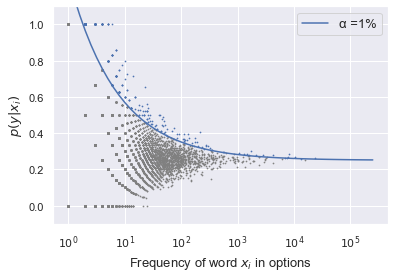

In [44]:
print(data_name)

Xhigh = []
Yhigh = []

Xmid = []
Ymid = []

Xlow = []
Ylow = []

for v in vocab:
    p = vocab[v]['freq']
    x = math.log(p) / math.log(10)
    y = vocab[v]['prob']
    high_boundary = 2.33 * math.sqrt(0.25 * 0.75 / 10 ** x) + 0.25
    low_boundary = -2.33 * math.sqrt(0.25 * 0.75 / 10 ** x) + 0.25
    if y > high_boundary:
        Xhigh.append(x)
        Yhigh.append(y)
    # elif y < low_boundary:
    elif False:
        Xlow.append(x)
        Ylow.append(y)
    else:
        Xmid.append(x)
        Ymid.append(y)

    # z = (y - 0.25) / math.sqrt(0.25 * 0.75 / p)
    # Z[v] = z
size = 2
plt.scatter(Xhigh, Yhigh, marker='.', color='C0', s=size)
plt.scatter(Xmid, Ymid, marker='.', color='gray', s=size)
# plt.scatter(Xlow, Ylow, marker='.', color='C1', s=size)


Xplot = [0.1 * i for i in range(55)]

Yplot_upper = [ 2.33 * math.sqrt(0.25 * 0.75 / 10 ** x) + 0.25 for x in Xplot]
Yplot_lower = [ -2.33 * math.sqrt(0.25 * 0.75 / 10 ** x) + 0.25 for x in Xplot]

plt.plot(Xplot, Yplot_upper, color='C0', label='α =1%')
# plt.plot(Xplot, Yplot_lower, color='C1')

plt.xticks([0, 1, 2, 3, 4, 5], ['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$'], size=11)
plt.ylim(-0.1, 1.1)
plt.xlabel('Frequency of word $x_i$ in options', size=13)
plt.ylabel('$p(y|x_i)$', size=13)
plt.legend(fontsize=13)

In [82]:
sortedZ = sorted(Z.items(), key=lambda x: x[1])

In [92]:
sortedZ[-20:]

[('still', 8.371584807348908),
 ('about', 8.468725144606875),
 ('different', 8.633553233971561),
 ('or', 8.825894609202274),
 ('life', 8.866112058847547),
 ('positive', 8.91132788679007),
 ('probably', 8.919508528991598),
 ('mind', 8.93941843982621),
 ('both', 9.15177209629895),
 ('some', 9.262899818139202),
 (',', 9.320269439394076),
 ('something', 9.771763639228007),
 ('of', 9.77779021541762),
 ('objective', 10.014275524755362),
 ('might', 10.539303728279354),
 ('c', 13.529628504050919),
 ('b', 16.484449451145487),
 ('may', 20.66054087385846),
 ('above', 20.713908915129547),
 ('and', 23.645075672987726)]

In [93]:
vocab['still']

{'true': 316, 'false': 527, 'prob': 0.3748517200474496, 'freq': 843}